In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as pt
import numpy as np

In [2]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [3]:
np.random.seed(10)
IMG_SIZE = 8
MIN_OBJECT_SIZE = 1
MAX_OBJECT_SIZE = 4
TRAIN_SAMPLES = 10000
VAL_SAMPLES = 500
BATCH_SIZE = 500

In [4]:
def create_samples(NUM_IMAGES,train=False):
    dataset = np.zeros((NUM_IMAGES,IMG_SIZE,IMG_SIZE))
    bboxes = []
    for i in range(NUM_IMAGES):
        w,h = np.random.randint(MIN_OBJECT_SIZE,MAX_OBJECT_SIZE+1,size=2)
        x = np.random.randint(0,IMG_SIZE-w)
        y = np.random.randint(0,IMG_SIZE-h)
        dataset[i,y:y+h,x:x+w,] = 1
        if train:
            bboxes.append([x,y,w,h])
    if train:
        return dataset, bboxes
    else:
        return dataset

In [5]:
trainset,bboxes = create_samples(TRAIN_SAMPLES,True)
valset,valbboxes = create_samples(VAL_SAMPLES,True)

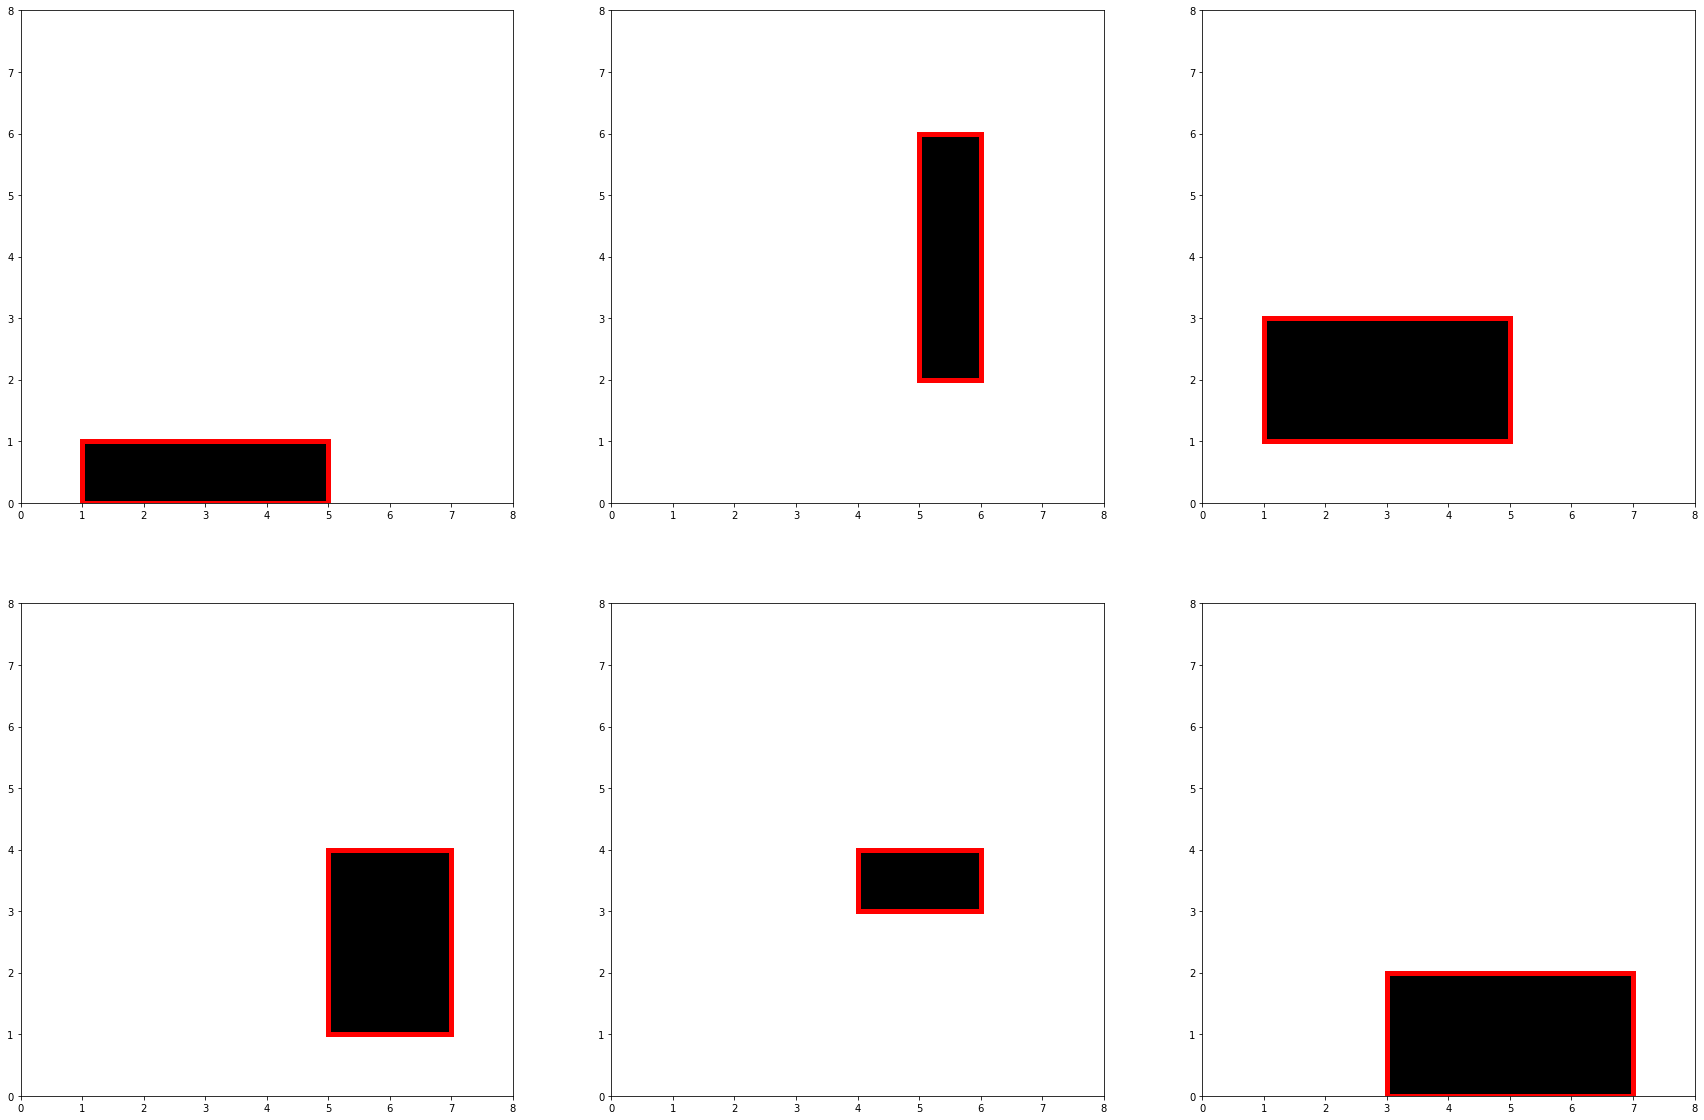

In [6]:
#Plot some data with bounding boxes

a = np.random.randint(50)
fig = plt.figure(figsize=(30,20))
for id, i in enumerate(trainset[a:a+6]):
    fig.add_subplot(2,3,id+1)
    bbox = bboxes[a+id]
    plt.imshow(i,cmap="binary",interpolation='none',
               origin='lower', extent=[0, IMG_SIZE, 0, IMG_SIZE])
    plt.gca().add_patch(pt.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],
                                     ec="r", fc="none", lw=5))
plt.show()

In [7]:
trainset_tensor = torch.Tensor(trainset).view(-1,IMG_SIZE*IMG_SIZE)
trainset_label_tensor = torch.Tensor(bboxes).view(-1,4)
valset_tensor = torch.Tensor(valset).view(-1,IMG_SIZE*IMG_SIZE)

In [8]:
trainset = data.TensorDataset(trainset_tensor,trainset_label_tensor)
trainloader = data.DataLoader(trainset,batch_size=BATCH_SIZE, num_workers=4)
valloader = data.DataLoader(valset,batch_size=BATCH_SIZE, num_workers=4)

In [9]:
class MLP(nn.Module):
    def __init__(self,inp,out):
        super(MLP,self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(inp,300),
            nn.Linear(300,100),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(100,out)
        )
    def forward(self,x):
        return self.fc(x)

In [10]:
def iou_calculate(predicted, truth):
    x_1 = predicted[0]
    y_1 = predicted[1]
    x_w_1 = predicted[0] + predicted[2]
    y_h_1 = predicted[1] + predicted[3]

    x_2 = truth[0]
    y_2 = truth[1]
    x_w_2 = truth[0] + truth[2]
    y_h_2 = truth[1] + truth[3]
    # tính overlap theo ox,oy .Nếu ko giao nhau trả về 0
    overlap_x = max(0,min(x_w_1,x_w_2) - max(x_1,x_2))
    overlap_y = max(0,min(y_h_1,y_h_2) - max(y_1,y_2))
    # tính area overlap
    overlap_area = overlap_x*overlap_y
    # tính total area hợp của 2 detection
    total_area = predicted[2]*predicted[3] + truth[2]*truth[3] - overlap_area

    return np.round(overlap_area/float(total_area),3)

In [11]:
def train(model, optimizer, error, trainloader):
    
    model.train()
    for id, (img,bbox) in enumerate(trainloader):
        optimizer.zero_grad()
        img = Variable(img).view(-1,IMG_SIZE*IMG_SIZE).to(device)
        label = Variable(bbox).view(-1).to(device)
        prediction = model(img).view(-1)
        loss = error(prediction,label)
        loss.backward()
        optimizer.step()
    return loss.data

In [12]:
def evaluate(model, optimizer, error, valloader):
    
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for id, (img,label) in enumerate(valloader):
            img = Variable(img).view(-1,IMG_SIZE*IMG_SIZE).to(device)
            label = Variable(bbox).view(-1).to(device)
            prediction = model(img).view(-1)


            loss = error(prediction,label)   
    return loss.data

In [13]:
model = MLP(IMG_SIZE*IMG_SIZE,4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
error = nn.MSELoss()

In [14]:
EPOCHS = 100
loss_list = []
for epoch in range(EPOCHS):
    loss = train(model,optimizer,error,trainloader)
    loss_list.append(loss)
    print("Epoch: {}, Loss: {}".format(epoch,loss))

Epoch: 0, Loss: 2.426729440689087
Epoch: 1, Loss: 1.4616005420684814
Epoch: 2, Loss: 0.9919004440307617
Epoch: 3, Loss: 0.7942426800727844
Epoch: 4, Loss: 0.695111870765686
Epoch: 5, Loss: 0.6624396443367004
Epoch: 6, Loss: 0.6225138306617737
Epoch: 7, Loss: 0.577736496925354
Epoch: 8, Loss: 0.5473270416259766
Epoch: 9, Loss: 0.5244342088699341
Epoch: 10, Loss: 0.5053961277008057
Epoch: 11, Loss: 0.49578768014907837
Epoch: 12, Loss: 0.4733750820159912
Epoch: 13, Loss: 0.44815921783447266
Epoch: 14, Loss: 0.4220564663410187
Epoch: 15, Loss: 0.40037015080451965
Epoch: 16, Loss: 0.39063456654548645
Epoch: 17, Loss: 0.3699612617492676
Epoch: 18, Loss: 0.36659955978393555
Epoch: 19, Loss: 0.3543359339237213
Epoch: 20, Loss: 0.3329671323299408
Epoch: 21, Loss: 0.3056703507900238
Epoch: 22, Loss: 0.30013391375541687
Epoch: 23, Loss: 0.2708848714828491
Epoch: 24, Loss: 0.2598307132720947
Epoch: 25, Loss: 0.25827816128730774
Epoch: 26, Loss: 0.22455942630767822
Epoch: 27, Loss: 0.23810324072837

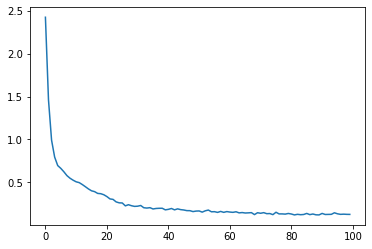

In [15]:
plt.plot(range(EPOCHS),loss_list)
plt.show()

In [16]:
testset,testbbox = create_samples(10,True)
testset_tensor = torch.Tensor(testset).view(-1,IMG_SIZE*IMG_SIZE)
testset_tensor = Variable(testset_tensor).view(-1,IMG_SIZE*IMG_SIZE).to(device)
with torch.no_grad():
    prediction = model(testset_tensor)

predicted_bboxes = prediction.cpu().numpy()

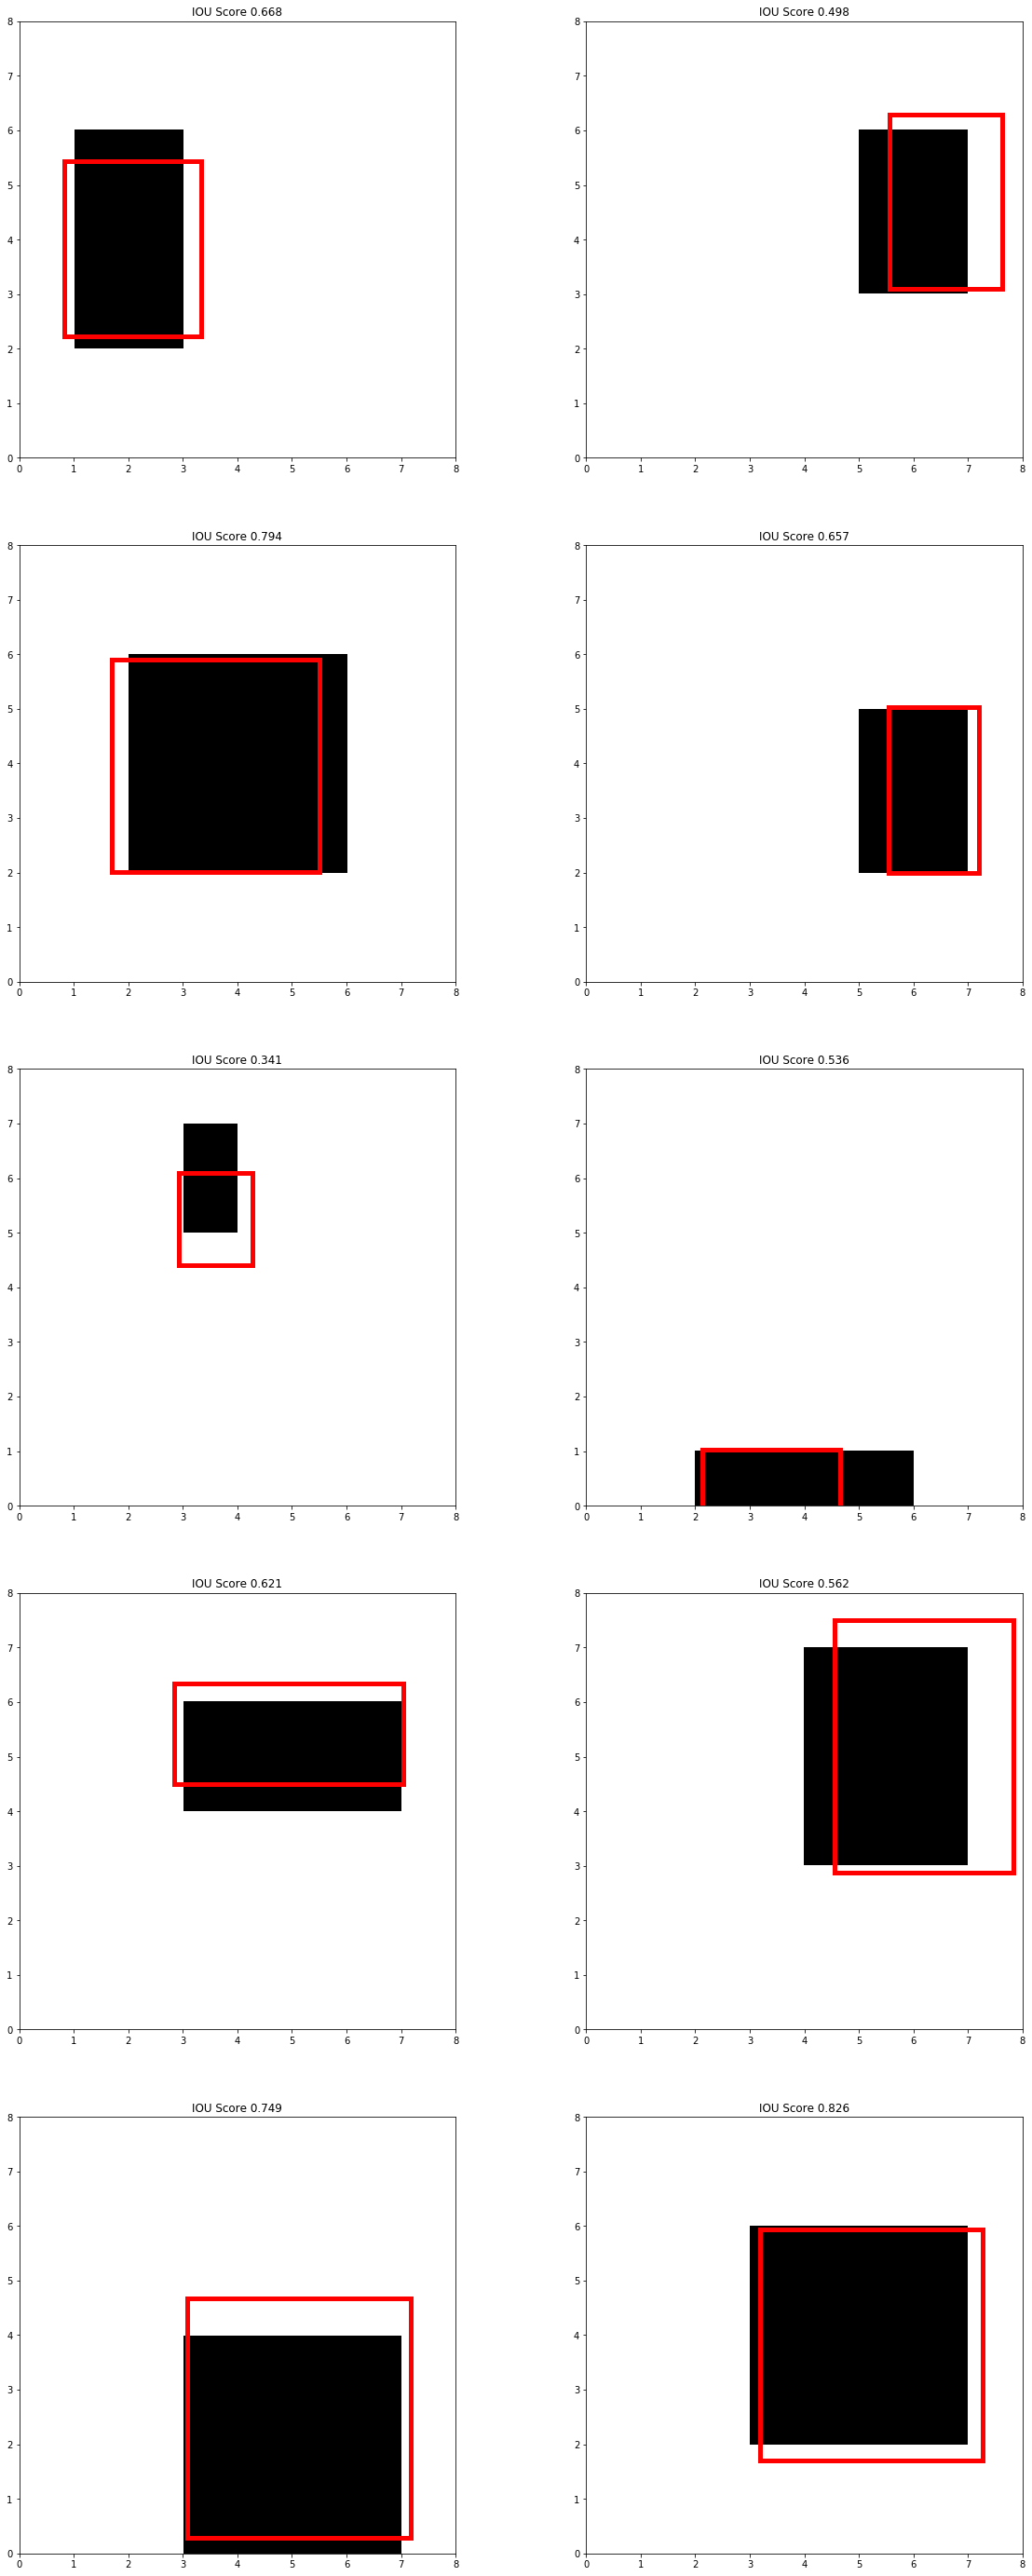

In [17]:

fig = plt.figure(figsize=(20,50))
for id, i in enumerate(testset[:10]):
    fig.add_subplot(5,2,id+1)
    bbox = predicted_bboxes[id]
    iou = iou_calculate(bbox, testbbox[id])
    plt.title("IOU Score "+str(iou))
    plt.imshow(i,cmap="binary",interpolation='none',
               origin='lower', extent=[0, IMG_SIZE, 0, IMG_SIZE])
    plt.gca().add_patch(pt.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],
                                     ec="r", fc="none", lw=5))
plt.show()